In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import io

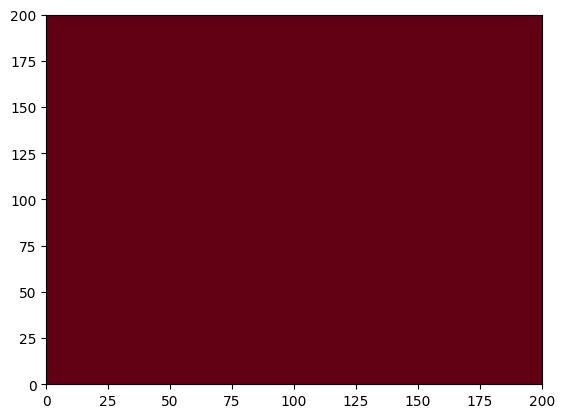

In [4]:
import matplotlib.patches

hex_code = '#610014'

fig = plt.figure()
ax = fig.add_subplot(111)

square_1 = matplotlib.patches.Rectangle((0, 0), 200, 200, color=f"{hex_code}")
ax.add_patch(square_1)
plt.xlim([0, 200])
plt.ylim([0, 200])

img_buf = io.BytesIO()
plt.savefig(img_buf, format='png')
plt.close(fig)
return img_buf